# W2D1 Tutorial 9: Thresholds

#### __Week 2, Day 4, Extremes & Vulnerability__
##### __Content creators:__ Matthias Aengenheyster, Joeri Reinders
##### __Content reviewers:__ TBD
##### __Content editors:__ TBD
##### __Production editors:__ TBD
##### __Our 2023 Sponsors:__ TBD

## Tutorial Objectives:

In this 9th tutorial we will look at extreme levels spatially, and consider the importance of thresholds. 

By the end of the tutorial you will be able to:
1. Assess the risk of increasing wet bulb temperatures.
2. Analyse how the probability of crossing threshold changes over time and between scenarios.
3. Analyse the results of a spatial GEV analysis

## Setup

In [1]:
# Installs

In [2]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [3]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !mamba install eigen numpy matplotlib seaborn pandas cartopy scipy texttable intake xarrayutils xmip cf_xarray intake-esm
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip


In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import seaborn as sns
import cmocean.cm as cmo

import os

#import cftime
#import nc_time_axis

import numpy as np
import cartopy.crs as ccrs
from scipy import stats

import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

gev = stats.genextreme

In [5]:
# def estimate_return_level(quantile,model):
#     loc, scale, shape = model.coef_
#     level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
#     # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
#     return level
def estimate_return_level_model(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level
def estimate_return_level_from_params(quantile,loc,scale,shape):
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

The human body has physiological limits within which it can operate. When it is very hot, the body cools through sweat, that is evaporating water off the skin, which cools the body through "latent heat loss". This depends on the ability of the air to take up that water. This is why sweating is more efficient in dry heat, and why humid heat feels "hotter" - it is harder for the body to cool down.

Consequently, the combination of temperature and humidity imposes limits on the body to regulate its temperature. One metric of the combined effect is the "wet bulb temperature", the temperature a thermometer shows when wrapped in a wet sock. https://en.wikipedia.org/wiki/Wet-bulb_temperature

Here we use wet bulb temperature calculated from the MPI-ESM1-2-HR climate model run by the Max Planck Institute for Meteorology in Hamburg, Germany, for the historical period, and three future climate scenarios.
1. hist: The historical scenario, which typically covers the range of 1851-2014. The climate model uses what we know about volcanic eruptions, greenhouse gas emission etc.
The SSP scenarios cover 'possible climate futures' after 2014. Therefore they are predictions ("this is what we think will happen") but projections ("this is plausible given the assumptions"). The different scenarios make different such assumptions, largely about the speed and ambition which which humanity addresses global warming and reduces the emission of the greenhouse gases and other pollutants. 
2. SSP-126: This is an 'ambitious' climate scenario, with fast emission reductions, and consequently relatively low levels of global warming and climate impacts.
3. SSP-245: This is a 'medium' climate scenario that may be reasonably close to a "best guess" given the current policy trajectory and assuming political behavior continues like this.
4. SSP-585: This is the most extreme climate scenario considered by the IPCC, with strong economic growth fueled by greenhouse gas emissions. It has the strongest warming of all considered scenarios, and is thus often used as a 'worst-case scenario' (sometimes inappropriately). Many experts nowadays considere this scenario to be quite unlikely given the strong improvement in the ambition of mitigation policies in the last 10 years or so.

In pre-processing, the data was averaged over 7-days and then the annual maximum was computed. Therefore, for each grid point, the data describes the wet bulb temperature of the most extreme 7-day period in each year..

In [6]:
import os, pooch

fname = 'WBGT_day_MPI-ESM1-2-HR_historical_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/69ms8/download"
    fname = pooch.retrieve(url, known_hash=None)

wetbulb_hist = xr.open_dataset(fname).WBGT

The data contains one entry per year. Because some years are leap years, the data processing step has given different days to the years. 
We find this undesirable for analysis. Therefore we resample the data (collect all the data points belonging to each year) and average them. 
Because there is only one data point per year, this does not modify the data, but only the time coordinate. 
Take from this to carefully inspect datasets that you open - often analysis workflows fail because such issues have been missed. 

In [7]:
wetbulb_hist = wetbulb_hist.resample(time='1Y').mean()

Let's load the data for the remaining scenarios:

In [8]:
# SSP-126
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/67b8m/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_126  = xr.open_dataset(fname).WBGT
wetbulb_126 = wetbulb_126.resample(time='1Y').mean()

# SSP-245
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/fsx5y/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_245 = xr.open_dataset(fname).WBGT
wetbulb_245 = wetbulb_245.resample(time='1Y').mean()

# SSP-585
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/pr456/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_585 = xr.open_dataset(fname).WBGT
wetbulb_585 = wetbulb_585.resample(time='1Y').mean()

Let's look at how the data is structured:

In [9]:
wetbulb_hist

<xarray.DataArray 'WBGT' (time: 64, lat: 192, lon: 384)>
array([[[-2.7235170e+01, -2.7209024e+01, -2.7091408e+01, ...,
         -2.7226376e+01, -2.7160492e+01, -2.7258596e+01],
        [-2.5137434e+01, -2.5155724e+01, -2.5227873e+01, ...,
         -2.5103416e+01, -2.5114450e+01, -2.5129984e+01],
        [-2.5405684e+01, -2.5478939e+01, -2.5416683e+01, ...,
         -2.5355572e+01, -2.5436531e+01, -2.5436386e+01],
        ...,
        [ 1.5202777e-01,  1.4101627e-01,  1.3330752e-01, ...,
          1.7247404e-01,  1.6777755e-01,  1.6128926e-01],
        [ 1.4682470e-01,  1.4339085e-01,  1.3746151e-01, ...,
          1.5303101e-01,  1.5185688e-01,  1.4891100e-01],
        [-6.8249358e-03, -7.0434422e-03, -8.7905107e-03, ...,
         -3.0952338e-03, -4.2250594e-03, -4.9193455e-03]],

       [[-2.6649139e+01, -2.6630531e+01, -2.6634752e+01, ...,
         -2.6691322e+01, -2.6607746e+01, -2.6625118e+01],
        [-2.5106850e+01, -2.5126314e+01, -2.5193607e+01, ...,
         -2.5092865e+01, -2.5098398e+01, -2.5103617e+01],
        [-2.5217392e+01, -2.5242710e+01, -2.5172596e+01, ...,
         -2.5080139e+01, -2.5190296e+01, -2.5223970e+01],
...
        [ 1.3378739e-01,  1.2870540e-01,  1.2770343e-01, ...,
          1.3989741e-01,  1.3784374e-01,  1.3685331e-01],
        [-4.5141011e-02, -4.6595134e-02, -5.1650975e-02, ...,
         -3.2980740e-02, -3.6983781e-02, -3.9977543e-02],
        [-1.8091998e-01, -1.8206993e-01, -1.8259056e-01, ...,
         -1.7845529e-01, -1.7992011e-01, -1.8005356e-01]],

       [[-2.5719893e+01, -2.5728792e+01, -2.5699797e+01, ...,
         -2.5871269e+01, -2.5829645e+01, -2.5588160e+01],
        [-2.3168945e+01, -2.3186224e+01, -2.3241858e+01, ...,
         -2.3076477e+01, -2.3144035e+01, -2.3166027e+01],
        [-2.2229086e+01, -2.2260471e+01, -2.2476068e+01, ...,
         -2.2073126e+01, -2.2129398e+01, -2.2191292e+01],
        ...,
        [-4.8862319e-02, -6.1266027e-02, -7.4026965e-02, ...,
         -1.7235180e-02, -2.6744476e-02, -3.6429971e-02],
        [-1.0998243e-01, -1.1364387e-01, -1.1661023e-01, ...,
         -9.9768467e-02, -1.0286019e-01, -1.0498482e-01],
        [-1.9145221e-01, -1.9040416e-01, -1.9016221e-01, ...,
         -1.9233751e-01, -1.9196975e-01, -1.9151381e-01]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * time     (time) datetime64[ns] 1951-12-31 1952-12-31 ... 2014-12-31

There is one data point per year on a latitude-longitude grid. Let's compute the grid spacing in the longitude and latitude directions:

In [10]:
wetbulb_hist.lon.diff('lon').values.mean()

0.9375

In [11]:
wetbulb_hist.lat.diff('lat').values.mean()

0.9349133773038073

Each box is about 1 degree by 1 degree. 1 degree latitude is approximately 110 km, 1 degree longitude is 110 km at the equator, which decreases when moving towards the poles.

So at the equator we are looking at 100-by-100 km grid boxes, somewhat less in the mid-latitudes. 

Can you think of limitations this induces?

## For now we focus the grid box that includes the city of New Delhi, India

In [12]:
wetbulb_hist_delhi = wetbulb_hist.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_126_delhi = wetbulb_126.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_245_delhi = wetbulb_245.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_585_delhi = wetbulb_585.sel(lon=77.21,lat=28.61,method='nearest')

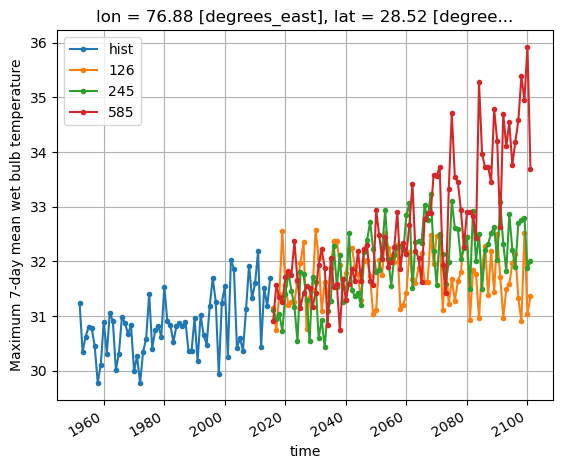

In [13]:
wetbulb_hist_delhi.plot.line('.-',label='hist')
wetbulb_126_delhi.plot.line('.-',label='126')
wetbulb_245_delhi.plot.line('.-',label='245')
wetbulb_585_delhi.plot.line('.-',label='585')

plt.legend()
plt.ylabel('Maximum 7-day mean wet bulb temperature')
plt.grid(True)

Note:
1. Trends are visible in the historical period
2. Clear differences between climate scenarios which become apparent at some point
3. Strong variability - each year is not necessarily warmer than the previous one

In [14]:
fit_hist, model_hist = ef.fit_return_levels_sdfc(wetbulb_hist_delhi.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)

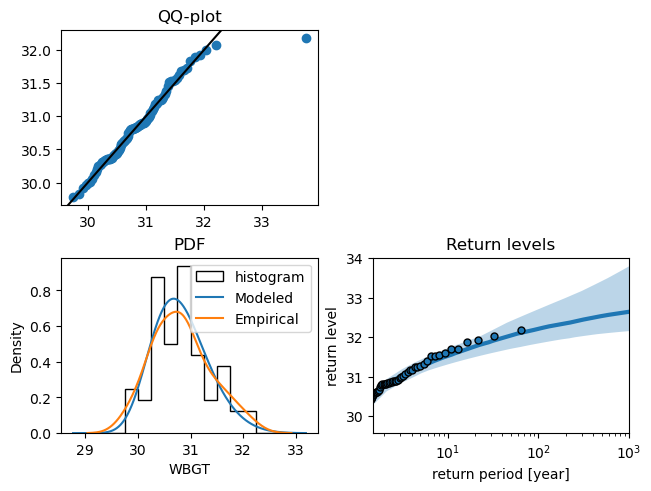

In [15]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, -fit_hist.xi.mean().values, loc=fit_hist.mu.mean().values, scale=fit_hist.sigma.mean().values), np.quantile(wetbulb_hist_delhi,x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_hist_delhi.min()-1, wetbulb_hist_delhi.max()+1, 1000)
wetbulb_hist_delhi.plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, -fit_hist.xi.mean().values, loc=fit_hist.mu.mean().values, scale=fit_hist.sigma.mean().values), label='Modeled')
sns.kdeplot(wetbulb_hist_delhi,ax=ax[2],label='Empirical')
ax[2].legend()

ef.plot_levels_from_obj(fit_hist,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [16]:
print('100-year return level: %.2f' % estimate_return_level_model(1-1/100,model_hist).mean())

100-year return level: 32.23


Now let's compare with the last 50 years of the SSP-245 scenario, the middle scenario we looked at before. 2050-2100 are approximately stationary here (we will check this next!)

In [17]:
fit_245, model_245 = ef.fit_return_levels_sdfc(wetbulb_245_delhi.sel(time=slice('2015','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)

# fit_245, model_245 = ef.fit_return_levels_sdfc(wetbulb_245_delhi.sel(time=slice('2051','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)

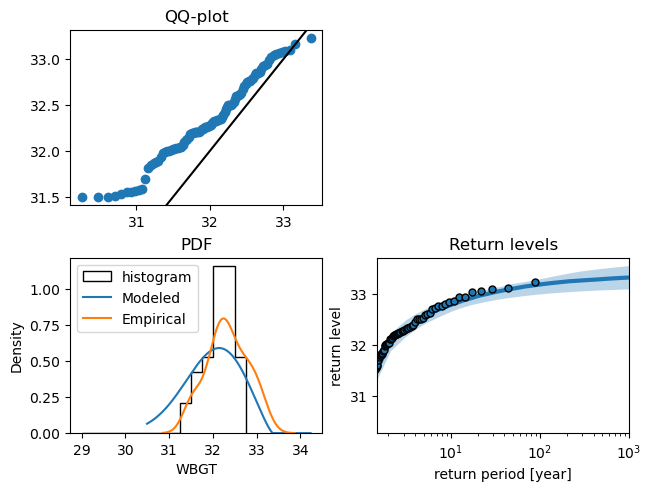

In [18]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, -fit_245.xi.mean().values, loc=fit_245.mu.mean().values, scale=fit_245.sigma.mean().values), np.quantile(wetbulb_245_delhi.sel(time=slice('2051','2100')),x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_245_delhi.sel(time=slice('2051','2100')).min()-1, wetbulb_245_delhi.sel(time=slice('2051','2100')).max()+1, 1000)
wetbulb_245_delhi.sel(time=slice('2051','2100')).plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, -fit_245.xi.mean().values, loc=fit_245.mu.mean().values, scale=fit_245.sigma.mean().values), label='Modeled')
sns.kdeplot(wetbulb_245_delhi.sel(time=slice('2051','2100')),ax=ax[2],label='Empirical')
ax[2].legend()

ef.plot_levels_from_obj(fit_245,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [19]:
print('100-year return level: %.2f' % estimate_return_level_model(1-1/100,model_245).mean())

100-year return level: 33.18


Compute as well the fit for the remaining two scenarios (SSP-126 and SSP-585).
You can then plot all results together to compare

In [20]:
fit_126, model_126 = ef.fit_return_levels_sdfc(wetbulb_126_delhi.sel(time=slice('2015','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)
fit_585, model_585 = ef.fit_return_levels_sdfc(wetbulb_585_delhi.sel(time=slice('2015','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)

# fit_126, model_126 = ef.fit_return_levels_sdfc(wetbulb_126_delhi.sel(time=slice('2051','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)
# fit_585, model_585 = ef.fit_return_levels_sdfc(wetbulb_585_delhi.sel(time=slice('2051','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)

(29.5, 37.0)

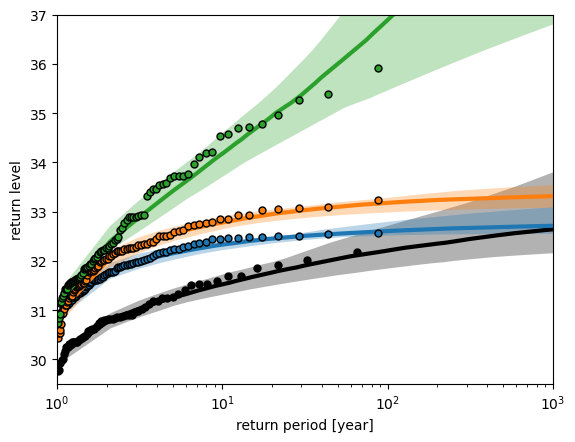

In [21]:
ef.plot_levels_from_obj(fit_hist,alpha=0.95,c='k')
ef.plot_levels_from_obj(fit_126,alpha=0.95,ax=plt.gca(),c='C0')
ef.plot_levels_from_obj(fit_245,alpha=0.95,ax=plt.gca(),c='C1')
ef.plot_levels_from_obj(fit_585,alpha=0.95,ax=plt.gca(),c='C2')


plt.xlim(1,1000)
plt.ylim(29.5,37)

## Exercise: What does this plot tell you about the event that could occur in the past compared to those that could occur under the different scenarios?

## Time-dependent return levels

Now we assume, as in the previous tutorial, the location parameter to be a function of time, and estimate the GEV distribution for the 4 scenarios:

In [22]:
law_ns_hist = sd.GEV()
law_ns_hist.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_245 = sd.GEV()
law_ns_245.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size))

law_ns_585 = sd.GEV()
law_ns_585.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size))

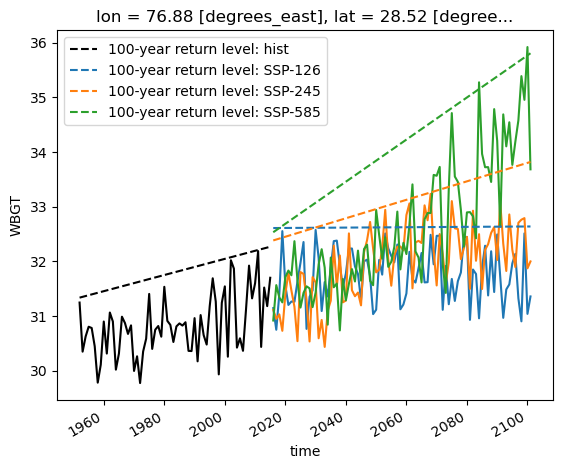

In [23]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level_model(1-1/100,law_ns_hist),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level_model(1-1/100,law_ns_126),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level_model(1-1/100,law_ns_245),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level_model(1-1/100,law_ns_585),'C2--',label='100-year return level: SSP-585')

plt.legend()

Now we again compute the AIC for the constant and time-dependent models, and compare their performance:

In [24]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info.optim_result.fun

In [25]:
aics = pd.DataFrame(columns=['hist','ssp126','ssp245','ssp585'],index=['constant','loc'])

aics['hist'] = compute_aic(model_hist), compute_aic(law_ns_hist)
aics['ssp126'] = compute_aic(model_126), compute_aic(law_ns_126)
aics['ssp245'] = compute_aic(model_245), compute_aic(law_ns_245)
aics['ssp585'] = compute_aic(model_585), compute_aic(law_ns_585)

In [26]:
aics.round(2)

,hist,ssp126,ssp245,ssp585
constant,108.71,122.02,174.87,261.98
loc,96.58,123.99,136.84,179.08


## Excercise: For which scenarios is it preferable to consider time information?
Additional question to explore: when looking at the plots, it appears that the SSP-126 and SSP-245 scenarios plateau after around 2050. You may want to repeat fitting the (non-time-varying) model while considering only data after 2050. Is the time-varying model still superior? The code for this is already commented out in the model-fitting code blocks above.

# Spatial analysis

After looking at one location, we now make use of the spatial information:

The commented code below fits the GEV distribution for each grid point. For the historical scenario this uses the entire time range, while for the scenarios we have chosen the period 2071-2100 - the last 30 years in the data. 

Because this takes some time to compute (around 9 minutes per dataset), so we have precomputed the data, and you DO NOT NEED TO RUN the commented code. Feel free to uncomment and run (and/or modify) the computation on your own time when you have the time to wait. You may also include time-dependent parameters (as shown above) or do other modifications, for example focus on a specific region.

Expensive code that fits a GEV distribution to each grid point:

In [ ]:
# fit_sp_hist = ef.fit_return_levels_sdfc_2d(wetbulb_hist.rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_hist.to_netcdf('wbgt_hist_raw_runmean7_gev.nc')
# fit_sp_126 = ef.fit_return_levels_sdfc_2d(wetbulb_126.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_126.to_netcdf('wbgt_126_raw_runmean7_gev_2071-2100.nc')
# fit_sp_245 = ef.fit_return_levels_sdfc_2d(wetbulb_245.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_245.to_netcdf('wbgt_245_raw_runmean7_gev_2071-2100.nc')
# fit_sp_585 = ef.fit_return_levels_sdfc_2d(wetbulb_585.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_585.to_netcdf('wbgt_585_raw_runmean7_gev_2071-2100.nc')

### Load pre-computed data:

In [28]:
# historical
fname = 'wbgt_hist_raw_runmean7_gev.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dakv3/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_hist = xr.open_dataset(fname)

# SSP-126
fname = 'wbgt_126_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/ef9pv/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_126 = xr.open_dataset(fname)

# SSP-245
fname = 'wbgt_245_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/j4hfc/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_245 = xr.open_dataset(fname)

# SSP-585
fname = 'wbgt_585_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/y6edw/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_585 = xr.open_dataset(fname)

Also load the area for each grid box - we will use this later to compute global averages:

In [29]:
fname = 'area_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/zqd86/download"
    fname = pooch.retrieve(url, known_hash=None)
area = xr.open_dataarray(fname)

fname = 'area_land_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dxq98/download"
    fname = pooch.retrieve(url, known_hash=None)
area_land = xr.open_dataarray(fname).fillna(0.)

Let's now look at the 100-year return level in the historical run, compared to 2071-2100 in the three scenarios. The colorbar was chosen to begin at 28 degrees, which is around the level experienced in the massive heatwaves in 2003 in Europe and 2010 in Russia:

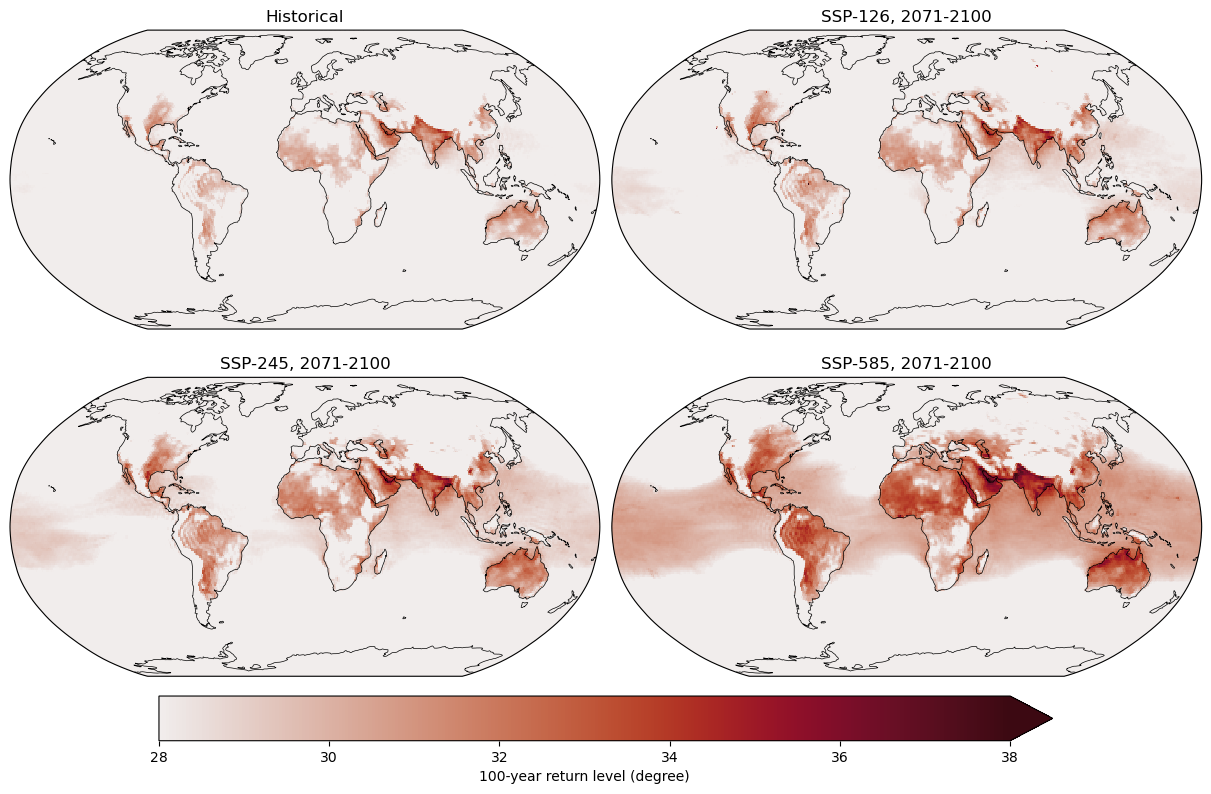

In [31]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=28,
    vmax=38,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = fit_sp_hist['return level'].sel({'return period':100},method='nearest').plot(ax=ax[0],**kwargs)
fit_sp_126['return level'].sel({'return period':100},method='nearest').plot(ax=ax[1],**kwargs)
fit_sp_245['return level'].sel({'return period':100},method='nearest').plot(ax=ax[2],**kwargs)
fit_sp_585['return level'].sel({'return period':100},method='nearest').plot(ax=ax[3],**kwargs)

cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='100-year return level (degree)',extend='max')

ax[0].set_title('Historical')
ax[1].set_title('SSP-126, 2071-2100')
ax[2].set_title('SSP-245, 2071-2100')
ax[3].set_title('SSP-585, 2071-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

The following plot gives a red shading to regions where the hottest heatwave is above 31 degrees wet bulb temperature, which is considered a "critical temperature" above which a human will die within a few hours:

Text(0.5, 0.98, 'Shaded regions for most extreme heatwave is > 31 WBGT')

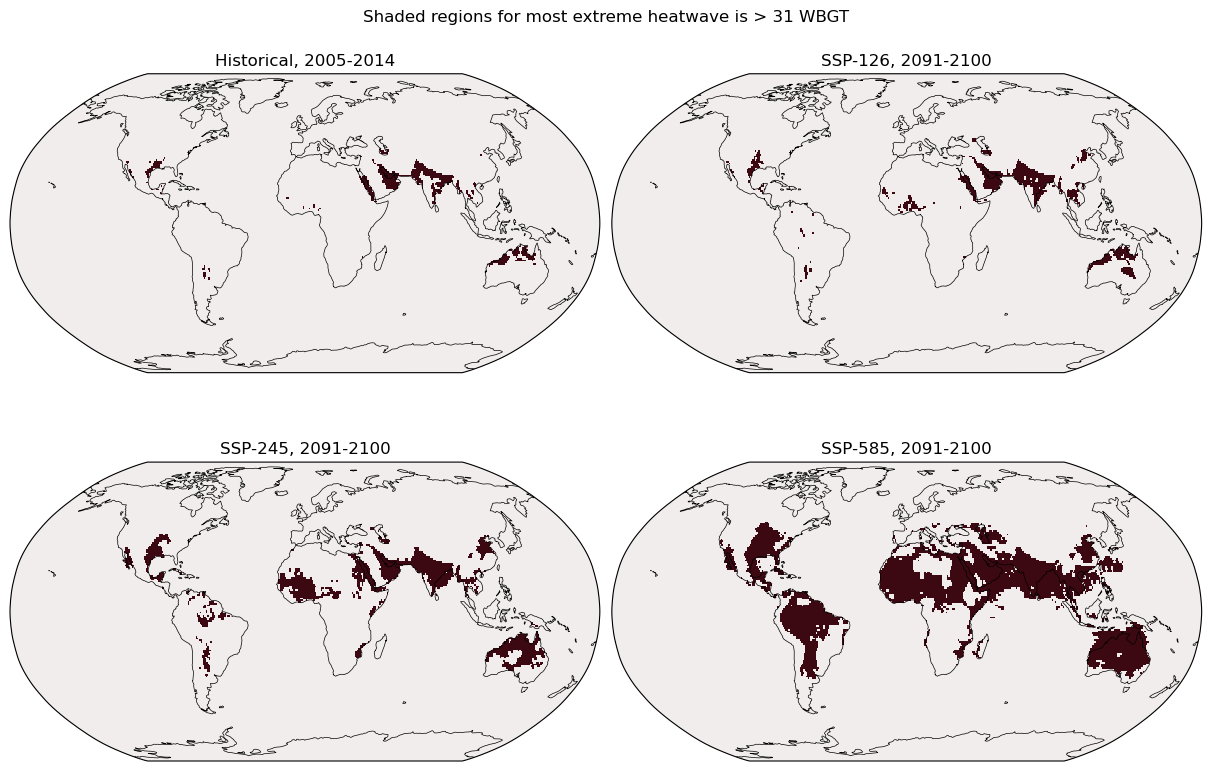

In [59]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=0,
    # vmin=20,
    # vmax=37,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = (wetbulb_hist.sel(time=slice('2005','2014')).max('time')>31).plot(ax=ax[0],**kwargs)
(wetbulb_126.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[1],**kwargs)
(wetbulb_245.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[2],**kwargs)
(wetbulb_585.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[3],**kwargs)

# cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='Most extreme 7-day mean WBGT')

ax[0].set_title('Historical, 2005-2014')
ax[1].set_title('SSP-126, 2091-2100')
ax[2].set_title('SSP-245, 2091-2100')
ax[3].set_title('SSP-585, 2091-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

fig.suptitle('Shaded regions for most extreme heatwave is > 31 WBGT')

Now we want to look at how the fraction of the Earth's land surface that experiences such extreme heatwaves changes over time. For this we need the area of each grid box which have been loaded previously. 

We then take the temporal-spatial data and assign it the value "1" if it exceeds the threshold and the value "0" if it does not. Performing area-weighted averaging over the whole land area of the world gives the fraction of land area that experiences a heat wave above the threshold in each year.

Text(0.5, 1.0, 'Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

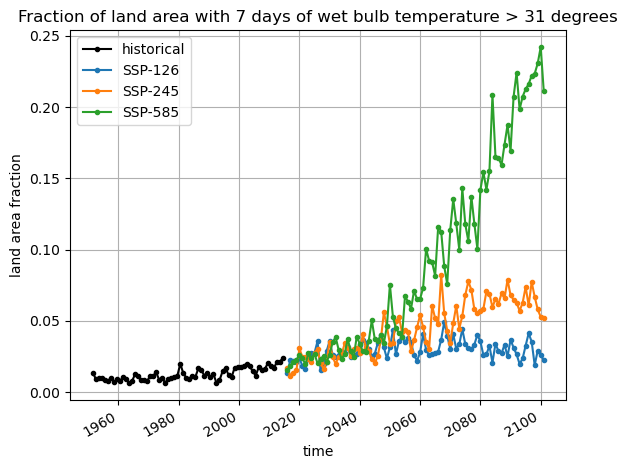

In [74]:
((wetbulb_hist>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('k.-',label='historical')
((wetbulb_126>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-126')
((wetbulb_245>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-245')
((wetbulb_585>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-585')

plt.grid(True)

plt.legend()
plt.ylabel('land area fraction')
plt.title('Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

In [43]:
print('Fraction of the land area of the world that experiences a heatwave above wet bulb temperature of 31 in the last 10 years of each run:')
(pd.Series(
    index=['historical','SSP-126','SSP-245','SSP-585'],
    data=[
    ((wetbulb_hist>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_126>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_245>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_585>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values
    ]
).astype(float) * 100).round(2)

Fraction of the land area of the world that experiences a heatwave above wet bulb temperature of 31 in the last 10 years of each run:


historical     1.82
SSP-126        2.75
SSP-245        6.24
SSP-585       21.89
dtype: float64

## Excercise: 
1. What do you see when looking at the time evolution and compare scenarios?
2. Re-compute this for a few different temperature threshold, we suggest 31, 28 and 33 degrees. How does the relative difference between scenarios change when choosing higher or lower thresholds?


## solution:

We see that a smaller fraction of the Earth experiences more extreme heat waves - as expected.

However, the difference between the scenarios becomes larger for more extreme events:
The area fraction that experiences heat waves above 28 degrees increases by 51.05 / 20.68 = 2.46 times between historical and SSP-585 scenarios, but for heat waves above 33 degrees it is 5.18 / 0.15 = 34.53 times!